What the important is not the arrival point, it is the journey itself. Enjoy your journey :)

# Including 
* Single-Particle Theta and Real Space Hopping Phases
* Essential First Band Approximation Functions

In [42]:
using NBInclude
@nbinclude("Hofstadter Single Particle in Theta Space.ipynb")
@nbinclude(joinpath("..","First Band Approximation Functions.ipynb"));

# Initial Parameters

In [79]:
# Lattice Size
Nx=3; Ny=3; N=Nx*Ny

# Magnetic Flux Per Plaquet
p=1; q=Ny; alpha=p/q

# Total Particle Number
PN=[0,1,2]

# Cut-Off for Sub-Space (Real Space for now...)
cut_off=9

# Interaction Potential
U = 2

# Theta Parameter Space
T_size=6;

# Single Particle Operator

In [44]:
function Sp_Theta_Op(Nx, Ny, alpha, sp_basis, Tx, Ty)
        
    H_T = HSP_T(Nx, Ny, alpha, Tx, Ty, 0)
    
    H = SparseOperator(sp_basis)
    
    for m in 1:N
        for n in 1:N
            H = H + H_T[m,n] * transition(sp_basis, m, n)
        end
    end
    
    return H
end

Sp_Theta_Op (generic function with 1 method)

In [46]:
using LinearAlgebra

# Reference Parameters
Tx = Ty = 0
sp_basis = NLevelBasis(N)
eigenenergies(dense(Sp_Theta_Op(Nx, Ny, alpha, sp_basis, Tx, Ty))) == eigvals(HSP_T(Nx, Ny, p/q, Tx, Ty, 0))
eigvals(HSP_T(Nx, Ny, p/q, Tx, Ty, 0))

9-element Vector{Float64}:
 -2.7320508075688794
 -2.7320508075688776
 -2.7320508075688767
  0.7320508075688769
  0.7320508075688776
  0.732050807568878
  1.9999999999999998
  2.0
  2.000000000000001

# Sub-Space Many-Body

In [47]:
@nbinclude("Hofstadter MB in Julia.ipynb"; regex=r"#.*executeme");

In [48]:
basis_cut_mb, basis_cut_sp = get_Bosonic_MB_Basis(cut_off,PN);

In [49]:
function get_total_H(Nx, Ny, alpha, sp_basis, Tx, Ty, cut_off, PN, basis_cut_sp, basis_cut_mb)
    # Single Particle Operator
    H1 = Sp_Theta_Op(Nx, Ny, alpha, sp_basis, Tx, Ty)
    
    # Sub-States Go on to Cut-Off
    sub_states = get_sub_states(H1, cut_off)

    # Sub-Space Basis and Projection Operator
    basis_sub, P, Pt = get_projector_op(sub_states, sp_basis)

    # Single-Particle Sub-Space Operator
    H1_sub = get_subspace_op(H1, P, Pt)

    # Many-Body Sub-Space Bosonic Fock States
    states_mb = bosonstates(basis_sub, PN)     

    # Many-Body Sub-Space Basis
    basis_mb = ManyBodyBasis(basis_sub, states_mb)

    # Kinetic Term of Many-Body Sub-Space Operator
    H1_MB = get_mb_op(basis_mb, basis_sub, H1_sub)
    H1cut = SparseOperator(basis_cut_mb)
    H1cut.data = H1_MB.data

    # Interaction Term of Many-Body Sub-Space Operator
    H_Int = Hubbard_Interaction(basis_cut_sp, basis_cut_mb, P, Pt, cut_off)
    
    return H1cut + H_Int
end

get_total_H (generic function with 1 method)

In [50]:
PN

3-element Vector{Int64}:
 0
 1
 2

In [51]:
Tx = Ty = 0
H_total = get_total_H(Nx, Ny, alpha, sp_basis, Tx, Ty, cut_off, PN, basis_cut_sp, basis_cut_mb);
eigenenergies(dense((H_total+H_total')/2))

55-element Vector{Float64}:
 -5.340971176014517
 -5.340971176014516
 -5.340971176014511
 -5.066168265618839
 -5.0661682656188365
 -5.0661682656188285
 -2.732050807568879
 -2.7320508075688776
 -2.7320508075688767
 -1.8128503544788719
 -1.81285035447887
 -1.8128503544788679
 -1.70457033693117
  ⋮
  3.26848260975546
  3.268482609755461
  3.2684826097554645
  3.64575131106459
  3.64575131106459
  3.6457513110645925
  4.519542897531031
  4.519542897531036
  4.519542897531037
  4.662503113875361
  4.662503113875364
  4.662503113875365

# Exact Diagonalization

In [52]:
using DataFrames

function get_filtered_energies(pn, basis, H_total)
    
    # Operator Form of Eigenstates
    E, V = eigenstates(dense(dense((H_total+H_total')/2)))

    # Energies According to Each Particle Number
    PN_Energies = Array{Float64}(undef, length(E), 2)
    for i in 1:length(E)
        # Particle Number in Each State
        PN_Energies[i] = round(expect(number(basis), V[i]))
        
        # Energies in Each State
        PN_Energies[i,2] = E[i]
    end
    
    # Fiter Process
    Filtered_Energies = DataFrame(PN_Energies, :auto)
    Filtered_Energies = filter(row -> (row.x1 == pn),  Filtered_Energies)
    
    return Filtered_Energies
end

get_filtered_energies (generic function with 1 method)

In [53]:
# Energies of Filtered Particle Number 
pn = 1
df = get_filtered_energies(pn, basis_cut_mb, H_total)
filtered_energies = Matrix(df)[:,2]

9-element Vector{Float64}:
 -2.732050807568879
 -2.732050807568878
 -2.732050807568876
  0.7320508075688756
  0.7320508075688765
  0.7320508075688766
  1.999999999999998
  2.0
  2.0

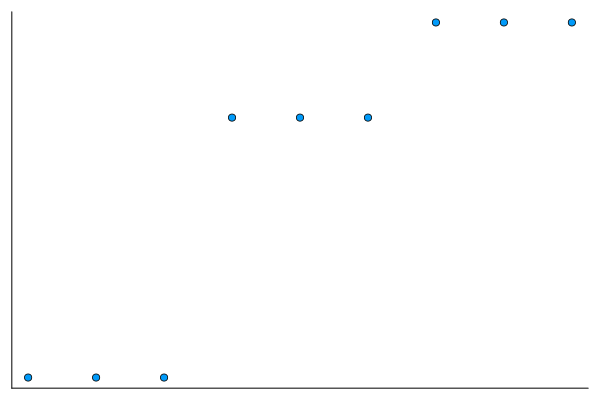

In [54]:
using Plots

# Plots Bands
scatter(1:length(filtered_energies), filtered_energies, legend=false, axis=nothing)

In [55]:
# Eigen-States of Filtered Particle Number 
function Filtered_Hubbard_States(filtered_energies, states)
    number_of_states = length(filtered_energies)
    return states[:,1:number_of_states]
end

Filtered_Hubbard_States (generic function with 1 method)

In [56]:
# # Calculate the Matrix Form to Get Eigenstates as Matrix Form
# function get_Matrix_form(basis_cut_mb, H_total)
#     # Convert the Hamiltonian from Operator to Matrix Form
#     H_Total_Matrix = zeros(Complex{Float64},length(basis_cut_mb),length(basis_cut_mb))
#     for i in 1:length(basis_cut_mb)
#         for j in 1:length(basis_cut_mb)
#             #H_Total_Matrix[i,j] = ((H_total+H_total')/2).data[i,j]
#             H_Total_Matrix[i,j] = H_total.data[i,j]
#         end
#     end
    
#     return H_Total_Matrix
# end

In [60]:
function get_eigenstates(basis_cut_mb, H_total, pn)
    
    # H_total_Matrix = get_Matrix_form(basis_cut_mb, H_total)
    # E = eigvals(H_total_Matrix)
    # V = eigvecs(H_total_Matrix)
    
    E, V = eigen(dense((H_total+H_total')/2).data)

    # Sorting Again...
    V = V[:, sortperm(E)]
    
    df = get_filtered_energies(pn, basis_cut_mb, H_total)
    filtered_energies = Matrix(df)[:,2]
    filtered_states = Filtered_Hubbard_States(filtered_energies, V)
    
    return filtered_energies, filtered_states
end

# Orthogonality 
filtered_energies, filtered_states = get_eigenstates(basis_cut_mb, H_total, pn)
for i in 1:N
    j = 9
    a = filtered_states[:,j]
    b = filtered_states[:,i]
    println(dot(a,b))
end

0.0 + 0.0im
0.0 + 0.0im
0.0 + 0.0im
0.0 + 0.0im
0.0 + 0.0im
0.0 + 0.0im
1.0755285551056204e-16 - 1.734723475976807e-17im
6.938893903907228e-18 + 2.7755575615628914e-17im
1.0 + 0.0im


# CHERN CALCULATION SECTION

In [120]:
# Mesh Grid for Theta Space Parameter
dx=2*pi/T_size/3; dy=dx;
Tx=range(start=0, stop=2*pi-dx, step=dx)
Ty=range(start=0, stop=2*pi-dy, step=dy)
collect(Tx)

18-element Vector{Float64}:
 0.0
 0.3490658503988659
 0.6981317007977318
 1.0471975511965976
 1.3962634015954636
 1.7453292519943295
 2.0943951023931953
 2.443460952792061
 2.792526803190927
 3.141592653589793
 3.490658503988659
 3.839724354387525
 4.1887902047863905
 4.537856055185257
 4.886921905584122
 5.235987755982989
 5.585053606381854
 5.93411945678072

In [121]:
function Chern_Nums(n1, n2)
    
    Sum=0
    
    for tx in range(start=1, stop=length(Tx))
        for ty in range(start=1, stop=length(Ty))
            
            H_Total = get_total_H(Nx, Ny, alpha, sp_basis, Tx[tx], Ty[ty], cut_off, PN, basis_cut_sp, basis_cut_mb)
            
            w1, v1 = get_eigenstates(basis_cut_mb, H_Total, pn)
            
            # sorting eigenvalues
            i = sortperm(w1, by=real);w1 = w1[i]
            # sorting eigenstates
            v1 = v1[:,i]
            # multiplet eigenstates
            v1 = v1[:,n1:n2]
            
            #------------------------------------
            H_Total = get_total_H(Nx, Ny, alpha, sp_basis, Tx[tx]+dx, Ty[ty], cut_off, PN, basis_cut_sp, basis_cut_mb)
            
            w2, v2 = get_eigenstates(basis_cut_mb, H_Total, pn)
            
            i = sortperm(w2, by=real);w2 = w2[i]
            v2 = v2[:,i]
            v2 = v2[:,n1:n2]
            
            #------------------------------------
            H_Total = get_total_H(Nx, Ny, alpha, sp_basis, Tx[tx], Ty[ty]+dy, cut_off, PN, basis_cut_sp, basis_cut_mb)
            
            w3, v3 = get_eigenstates(basis_cut_mb, H_Total, pn);
            
            i = sortperm(w3, by=real);w3 = w3[i]
            v3 = v3[:,i]
            v3 = v3[:,n1:n2]
            
            #------------------------------------
            H_Total = get_total_H(Nx, Ny, alpha, sp_basis, Tx[tx]+dx, Ty[ty]+dy, cut_off, PN, basis_cut_sp, basis_cut_mb)
            
            w4, v4 = get_eigenstates(basis_cut_mb, H_Total, pn)
            
            i = sortperm(w4, by=real);w4 = w4[i]
            v4 = v4[:,i]
            v4 = v4[:,n1:n2]
            
            #----------LINK VARIABLES------------
            U1=det(adjoint(v1)*v2)
            U1=U1/abs(U1)
            U2=det(adjoint(v2)*v4)
            U2=U2/abs(U2)
            U3=det(adjoint(v3)*v4)
            U3=U3/abs(U3)
            U4=det(adjoint(v1)*v3)
            U4=U4/abs(U4)
            
            #----------BERRY CURVATURE-----------
            F=log(U1*U2*1/U3*1/U4)
            Sum=Sum+F
            
        end
    end
    
    return 1/(2*pi*1im)*Sum
end

Chern_Nums (generic function with 1 method)

In [122]:
Chern_Nums(1, 3)

-2.264222001100316 + 4.541180701897191e-16im

# Check with "Hofstadter MB Chern" file

In [115]:
pn = 1
tx = 2
ty = 2
#---
H_Total = get_total_H(Nx, Ny, alpha, sp_basis, Tx[tx], Ty[ty], cut_off, PN, basis_cut_sp, basis_cut_mb)
w1, v1 = get_eigenstates(basis_cut_mb, H_Total, pn)
i = sortperm(w1, by=real);w1 = w1[i]
v1 = v1[:,i] 
#---
H_Total = get_total_H(Nx, Ny, alpha, sp_basis, Tx[tx]+dx, Ty[ty], cut_off, PN, basis_cut_sp, basis_cut_mb)
w2, v2 = get_eigenstates(basis_cut_mb, H_Total, pn)
i = sortperm(w2, by=real);w2 = w2[i]
v2 = v2[:,i]
#---
H_Total = get_total_H(Nx, Ny, alpha, sp_basis, Tx[tx], Ty[ty]+dy, cut_off, PN, basis_cut_sp, basis_cut_mb)       
w3, v3 = get_eigenstates(basis_cut_mb, H_Total, pn)
i = sortperm(w3, by=real);w3 = w3[i]
v3 = v3[:,i]
#---
H_Total = get_total_H(Nx, Ny, alpha, sp_basis, Tx[tx]+dx, Ty[ty]+dy, cut_off, PN, basis_cut_sp, basis_cut_mb)
w4, v4 = get_eigenstates(basis_cut_mb, H_Total, pn)
i = sortperm(w4, by=real);w4 = w4[i]
v4 = v4[:,i]
#---
U1=det(adjoint(v1)*v2)
U1=U1/abs(U1)
println(U1)
U2=det(adjoint(v2)*v4)
U2=U2/abs(U2)
println(U2)
U3=det(adjoint(v3)*v4)
U3=U3/abs(U3)
println(U3)
U4=det(adjoint(v1)*v3)
U4=U4/abs(U4)
println(U4)

-0.9481949908134405 - 0.31768893496044154im
NaN + NaN*im
NaN + NaN*im
0.7084226400508593 + 0.7057884690637632im


In [116]:
abs.(v2'*v4)

9×9 Matrix{Float64}:
 0.437477  0.285883  0.258005  0.0667306  …  0.036542   0.025428   0.0581614
 0.251318  0.182989  0.405356  0.601795      0.0112634  0.098854   0.0514668
 0.129296  0.17343   0.788472  0.22678       0.0351068  0.0316351  0.043658
 0.321173  0.503505  0.221088  0.205927      0.0491771  0.0531957  0.0787021
 0.338882  0.649173  0.192941  0.536323      0.0496556  0.0499503  0.0152605
 0.687187  0.371908  0.190082  0.460822   …  0.0342674  0.0374584  0.0454747
 0.0       0.0       0.0       0.0           0.0        0.0        0.0
 0.0       0.0       0.0       0.0           0.0        0.0        0.0
 0.0       0.0       0.0       0.0           0.0        0.0        0.0

In [66]:
Tx[1]

0.0

In [67]:
w1

9-element Vector{Float64}:
 -2.5466393943271597
 -2.546639394327157
 -2.5466393943271535
  0.20750036611082506
  0.20750036611082523
  0.20750036611082567
  2.3391390282163353
  2.3391390282163353
  2.3391390282163362

In [68]:
w2

9-element Vector{Float64}:
 -2.361468766185828
 -2.361468766185824
 -2.361468766185822
 -0.1674491911085357
 -0.1674491911085325
 -0.16744919110852985
  2.528917957294362
  2.5289179572943623
  2.5289179572943628

In [69]:
w3

9-element Vector{Float64}:
 -2.3614687661858276
 -2.3614687661858267
 -2.3614687661858254
 -0.1674491911085362
 -0.16744919110853518
 -0.16744919110853407
  2.5289179572943565
  2.5289179572943614
  2.528917957294362

In [70]:
w4

9-element Vector{Float64}:
 -2.114064054711409
 -2.114064054711399
 -2.114064054711384
 -0.5702509472473359
 -0.5702509472473325
 -0.5702509472473313
  2.6843150019587316
  2.6843150019587343
  2.684315001958736

In [89]:
det(v4'*v4)

1.0000000000000033 + 2.6426961071036653e-47im

In [85]:
U1

NaN + NaN*im

In [84]:
v2

55×9 Matrix{ComplexF64}:
          0.0+0.0im          …           0.0+0.0im
          0.0+0.0im                      0.0+0.0im
          0.0+0.0im                      0.0+0.0im
          0.0+0.0im                      0.0+0.0im
          0.0+0.0im                      0.0+0.0im
          0.0+0.0im          …           0.0+0.0im
          0.0+0.0im                      0.0+0.0im
          0.0+0.0im                      0.0+0.0im
          0.0+0.0im                      0.0+0.0im
          0.0+0.0im                      0.0+0.0im
    0.0670832+0.354737im     …   2.35024e-17+1.30042e-16im
     0.277783-0.0922628im       -1.89151e-16+2.749e-16im
   -0.0744106+0.781685im         1.86595e-16-6.42858e-16im
             ⋮               ⋱  
   0.00147848-0.00244517im       1.29764e-16+1.96293e-16im
 -0.000235455-0.000992532im     -2.04152e-16-1.39365e-16im
  -0.00312523-0.0166034im    …   1.15219e-16-1.69812e-17im
  -0.00101419+0.000705102im      8.63899e-16+3.4278e-16im
    8.4419e-5+0.001367

In [27]:
v2

55×9 Matrix{ComplexF64}:
          0.0+0.0im          …           0.0+0.0im
          0.0+0.0im                      0.0+0.0im
          0.0+0.0im                      0.0+0.0im
          0.0+0.0im                      0.0+0.0im
          0.0+0.0im                      0.0+0.0im
          0.0+0.0im          …           0.0+0.0im
          0.0+0.0im                      0.0+0.0im
          0.0+0.0im                      0.0+0.0im
          0.0+0.0im                      0.0+0.0im
          0.0+0.0im                      0.0+0.0im
    -0.983447-5.10323e-18im  …    -0.0140821+3.7997e-17im
 -1.48023e-14+5.60472e-16im     -1.52659e-15-2.20146e-17im
  1.27999e-14+2.35198e-16im     -2.87481e-16+5.18328e-17im
             ⋮               ⋱  
  1.88908e-16+1.13064e-17im     -9.57624e-16-2.37539e-17im
   -0.0323342+5.47203e-17im       -0.0134113+3.76829e-17im
  1.28994e-16+1.08775e-18im  …   1.74001e-16-1.14905e-17im
  2.92751e-16-1.42657e-17im       1.1332e-15+2.60483e-17im
   -0.0120202+1.3556

In [28]:
v1'*v2

9×9 Matrix{ComplexF64}:
          1.0-1.25938e-33im  …  -2.84746e-17+6.93335e-32im
  4.37308e-18+1.93893e-19im     -3.01393e-19-6.07499e-20im
   -6.355e-19+3.286e-21im        3.99366e-20+1.46665e-20im
  6.54241e-18+3.66807e-19im     -5.11888e-18+5.24039e-19im
 -1.74373e-18-6.25124e-21im     -6.37714e-20-9.28722e-21im
  5.82008e-17-2.04019e-32im  …   3.11347e-17+2.46519e-31im
 -1.89753e-18+1.79296e-19im     -4.27887e-18+1.02508e-19im
          0.0+0.0im                      0.0+0.0im
 -2.84746e-17-6.93335e-32im              1.0+0.0im

In [29]:
# Another type of sorting method

v1 = v1[:, sortperm(w1)]
v2 = v2[:, sortperm(w2)]
det(v1'*v2))

LoadError: syntax: extra token ")" after end of expression